In [42]:
from os import path as op
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
from rasterio.plot import reshape_as_raster, reshape_as_image

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from treeinterpreter import treeinterpreter as ti

In [43]:
#read path to dataset
#image
img_path = '.\data\Opt_SAR_Stack.tif'
#traing and test dataset
tp_src = gp.read_file('.\data\sgcplot.shp')
tp_crop = gp.read_file('.\data\croplabel.shp')
tp_ncrop = gp.read_file(r'.\data\noncroplabel.shp')
# img_path

In [44]:
crop_label = tp_src.append(tp_crop).append(tp_ncrop)
crop_label = crop_label.to_crs(32736)
crop_label.tail()

,label,geometry
173,0,"POLYGON Z ((648605.608 9905622.155 0.000, 6486..."
174,0,"POLYGON Z ((649982.321 9906989.082 0.000, 6500..."
175,0,"POLYGON Z ((651832.614 9919062.149 0.000, 6518..."
176,0,"POLYGON Z ((651766.644 9918838.993 0.000, 6517..."
177,0,"POLYGON Z ((649204.564 9918381.849 0.000, 6492..."


In [45]:
classes = np.unique(crop_label.label)
classes

array([0, 1], dtype=int64)

In [46]:
class_dict = dict(zip(classes, range(len(classes))))
class_dict

{0: 0, 1: 1}

In [47]:
#Band list
all_band = ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B9", "B11", "B12", "NDVI", "EVI", "GCVI", "RDGCVI", "NDWI", "VH", "VV", "Sarrtio", "Sardiff"]

## Sample Extraction

In [48]:
#TODO - read more about rasterize without moving window
def all_value(x):
    return x

X_raw = []
y_raw = []

with rasterio.open(img_path, 'r') as src:
    for (label, geom) in zip(crop_label.label, crop_label.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
       # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [25]:
# print(y_raw)

In [49]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((11076, 20), (11076,))

### Random Forest model

In [50]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.0003484320557491289, 1: 0.00020479213598197828}

In [88]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
#     class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    oob_score=True,
    random_state=0)

In [89]:
# fit the model to the data (training)
clf.fit(X, y)

RandomForestClassifier(max_depth=6, n_jobs=-1, oob_score=True, random_state=0)

### Prediction report

In [90]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)
print('Confusion Matrix:',cm) #confusion matrix

Confusion Matrix: [[ 671  540]
 [  37 2075]]


In [91]:
from sklearn.metrics import accuracy_score
predaccuracy = accuracy_score(y_test, preds)
print('Overall accuracy:', predaccuracy)

Overall accuracy: 0.826361721336142


In [92]:
print(classification_report(y_test, preds, labels=labels))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70      1211
           1       0.79      0.98      0.88      2112

    accuracy                           0.83      3323
   macro avg       0.87      0.77      0.79      3323
weighted avg       0.85      0.83      0.81      3323



### Feature importance

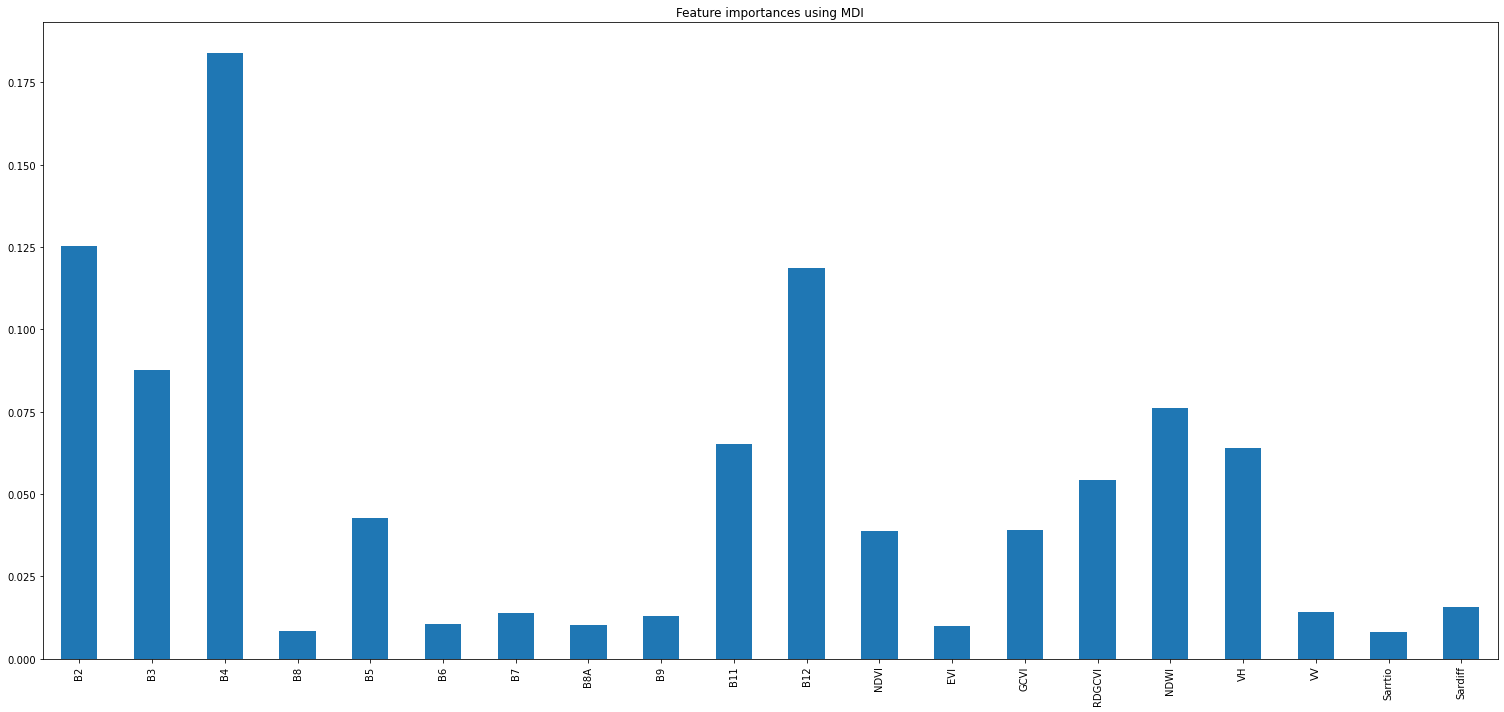

In [111]:
#feature importance
importance = pd.Series(clf.feature_importances_)
x_labels = all_band
fig, ax = plt.subplots()
importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xticklabels(x_labels)
fig.set_size_inches(21, 10)
fig.tight_layout()

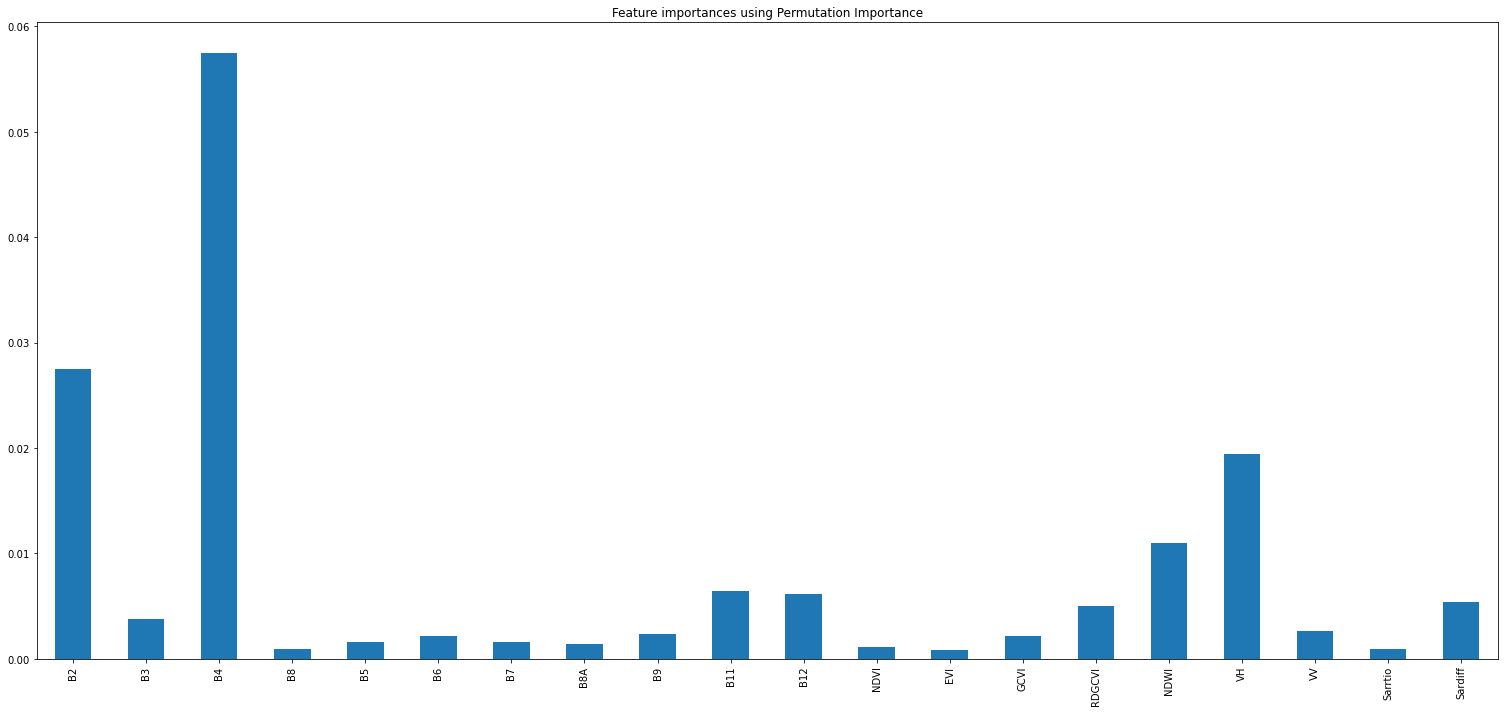

In [110]:
rimp = pd.Series(imp['importances_mean'])
x_labels = all_band
fig, ax = plt.subplots()
rimp.plot.bar(ax=ax)
ax.set_title("Feature importances using Permutation Importance")
# ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(x_labels)
fig.set_size_inches(21, 10)
fig.tight_layout()

In [35]:
#output path
out_dir = r'C:.\Sugarcane\sci-kit learn\result' 

## Image Classification

In [36]:
# predict over the entire input image
new_image = img_path

# specify the output
output_image = op.join(out_dir, "classification.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        data = src.read() #this read the image array as (bands, row, columns)
        temp = reshape_as_image(data) #--solution #:)
#         temp = data.transpose(2,1,0)#(rows, cols, layer) --error source
        temp_ = temp.reshape(-1, temp.shape[-1])#2d (all pixel in rows against the features)
        to_predict = np.nan_to_num(temp_, nan=-99999.999)
        
        #predict
        img_preds = clf.predict(to_predict)
        #restore to initial dimension
        output = img_preds.reshape(*temp.shape[:-1])
        #write output
        dst.write(output.astype(rasterio.uint8), 1)
        

In [37]:
output_image = r'C:.\Sugarcane\sci-kit learn\result\classification.tif' #output path

In [41]:
from rasterio.plot import show
def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float64(imax - imin)
    return image * (omax - omin) + omin


with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()
    
with rasterio.open(img_path, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
    s2 = s2.astype(np.uint8)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)    

In [39]:
#Numpy understand --

# tp = data.transpose(2,1,0)
# temp = tp.reshape(-1, tp.shape[-1]) #2d
# nonan = np.nan_to_num(temp, nan=0.0)
# nonan.shape
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(temp)
# nwtemp = imp.transform(temp)
# temp1d = temp.reshape(-1)
# temp1d.shape
# tp.shape
# temp.shape
# m = np.ma.masked_invalid(nwtemp)
# tott = nwtemp[~m.mask].reshape(-1, nwtemp.shape[-1])
# tott.shape
# newarr = np.reshape(tott,temp.shape[-1])
# newarr.shape

In [40]:
# x = np.zeros((3,4,5))
# xx = np.moveaxis(x,0,2).reshape(-1, x.shape[-1])
# xz = xx